_Version log: Branch of V19. Parameter scan accross number of pixels._

In [31]:
import sys, warnings, time
import numpy as np
import CS_functions as cs
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from matplotlib import ticker as ticker, pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from scipy.constants import c as C
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':24, 'lines.markersize': 8.0, 'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white', "xtick.minor.visible": True, "ytick.minor.visible": True})
#np.set_printoptions(threshold=sys.maxsize)

In [32]:
def interpolate(y, new_number_of_points):
    x = range(len(y))
    new_x = np.linspace(0, len(y) -1, new_number_of_points, endpoint= True)
    inter = spinter.interp1d(x, y, kind= "linear", bounds_error= False, fill_value= "extrapolate")
    return inter(new_x)

## TRAIN WITH NOISELESS INTERFEROGRAM

In [33]:
training_file_number = 27 # Use a noiseless version of the interferogram for good convergence
training_file_name = "1dmockanderrors{:d}".format(training_file_number)
#training_file_name = "240802134128_altered1d"

file_type = ".csv"
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

In [34]:
#LOOP INITIALISATION

unique_reduced_points = [3,4,5,6,7,8,9,10,12,14,16,18,20,25,30]
repetitions = 5
reduced_points = np.repeat(unique_reduced_points, repetitions)

training_target, training_uncertainties = cs.open_dataset(training_file_name, file_type)
training_uncertainties /= np.max(training_target)
training_target /= np.max(training_target) #normalise
training_peak = np.argmax(training_target)
total_point = len(training_target)


best_scores = {"Simulated Annealing": np.array([]),
               "MCMC Metropolis": np.array([]),
               "Douglas Peucker": np.array([]),
               "Greedy": np.array([])}
configurations = {"Simulated Annealing": [],
                    "MCMC Metropolis": [],
                    "Douglas Peucker": [],
                    "Greedy": []}
runtimes = {"Simulated Annealing": np.array([]),
            "MCMC Metropolis": np.array([]),
            "Douglas Peucker": np.array([]),
            "Greedy": np.array([])}

optlocs_file = "data\\" + training_file_name +"_optlocs.csv"

In [35]:
###################### THIS WILL TAKE A LONG TIME!!! #################

for reduced_point in tqdm(reduced_points):
    #compression = total_point /dataset.shape[1]
    #target = interpolate(dataset[0], total_point)
    #uncertainties = interpolate(dataset[1], total_point)

    t0 = time.time()
    detectors, score = cs.simulated_annealing(reduced_point, training_target, training_uncertainties, regularization_coeffient, "random", max_temp= 15, cooling= 0.999, iterations= 5000)
    runtimes["Simulated Annealing"] = np.append(runtimes["Simulated Annealing"], time.time() -t0)
    best_scores["Simulated Annealing"] = np.append(best_scores["Simulated Annealing"], score)
    configurations["Simulated Annealing"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.MCMC_metropolis(reduced_point, training_target, training_uncertainties, regularization_coeffient, "random", stepsize= 5, iterations= 5000)
    runtimes["MCMC Metropolis"] = np.append(runtimes["MCMC Metropolis"], time.time() -t0)
    best_scores["MCMC Metropolis"] = np.append(best_scores["MCMC Metropolis"], score)
    configurations["MCMC Metropolis"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.douglas_peucker(reduced_point, training_target, training_uncertainties, regularization_coeffient)
    runtimes["Douglas Peucker"] = np.append(runtimes["Douglas Peucker"], time.time() -t0)
    best_scores["Douglas Peucker"] = np.append(best_scores["Douglas Peucker"], score)
    configurations["Douglas Peucker"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

    t0 = time.time()
    detectors, score = cs.greedy(reduced_point, training_target, training_uncertainties, regularization_coeffient, "regular", iterations= 20)
    runtimes["Greedy"] = np.append(runtimes["Greedy"], time.time() -t0)
    best_scores["Greedy"] = np.append(best_scores["Greedy"], score)
    configurations["Greedy"] += [detectors]
    cs.append_array_to_csv(detectors, optlocs_file)

#np.split(configurations["Greedy"], np.cumsum(reduced_points)[:-1]) # shouldn't need this anymore

100%|██████████| 75/75 [43:15<00:00, 34.60s/it]


In [46]:
configurations["Greedy"]

[array([41, 26, 29]),
 array([41, 26, 29]),
 array([41, 26, 29]),
 array([41, 26, 29]),
 array([41, 26, 29]),
 array([30, 18, 21, 45]),
 array([30, 18, 21, 45]),
 array([30, 18, 21, 45]),
 array([30, 18, 21, 45]),
 array([30, 18, 21, 45]),
 array([ 1,  6, 26, 39, 29]),
 array([ 1,  6, 26, 39, 29]),
 array([ 1,  6, 26, 39, 29]),
 array([ 1,  6, 26, 39, 29]),
 array([ 1,  6, 26, 39, 29]),
 array([ 0, 34, 26, 31, 25, 12]),
 array([ 0, 34, 26, 31, 25, 12]),
 array([ 0, 34, 26, 31, 25, 12]),
 array([ 0, 34, 26, 31, 25, 12]),
 array([ 0, 34, 26, 31, 25, 12]),
 array([ 0, 46, 30, 26, 29,  6, 15]),
 array([ 0, 46, 30, 26, 29,  6, 15]),
 array([ 0, 46, 30, 26, 29,  6, 15]),
 array([ 0, 46, 30, 26, 29,  6, 15]),
 array([ 0, 46, 30, 26, 29,  6, 15]),
 array([ 0, 13, 36, 27, 30, 26,  8, 43]),
 array([ 0, 13, 36, 27, 30, 26,  8, 43]),
 array([ 0, 13, 36, 27, 30, 26,  8, 43]),
 array([ 0, 13, 36, 27, 30, 26,  8, 43]),
 array([ 0, 13, 36, 27, 30, 26,  8, 43]),
 array([28, 30, 13, 20, 26, 32, 34, 46, 

## TEST WITH NOISY INTERFEROGRAM

In [36]:
test_file_number = 26
test_file_name = "1dmockanderrors{:d}".format(test_file_number)
#test_file_name = "240802134128_processed1d"
regularization_coeffient = 1e-3

file_type = ".csv"
test_target, test_uncertainties = cs.open_dataset(test_file_name, file_type)
test_uncertainties /= np.max(test_target)
test_target /= np.max(test_target) #normalise
test_peak = np.argmax(test_target)

median_runtimes, mean_runtimes = {}, {}
for method, scores, configs in list(zip(best_scores.keys(), best_scores.values(), configurations.values())): # Re-evaluate all of the scores for a noisy version of the interferogram.
    for n, score, config in zip(range(len(scores)), scores, configs):
        config = config -training_peak +test_peak #recenter
        config = config %total_point #wrap around
        best_scores[method][n] = cs.evaluate_score(config, test_target, test_uncertainties, regularization_coeffient)
        configurations[method][n] = config

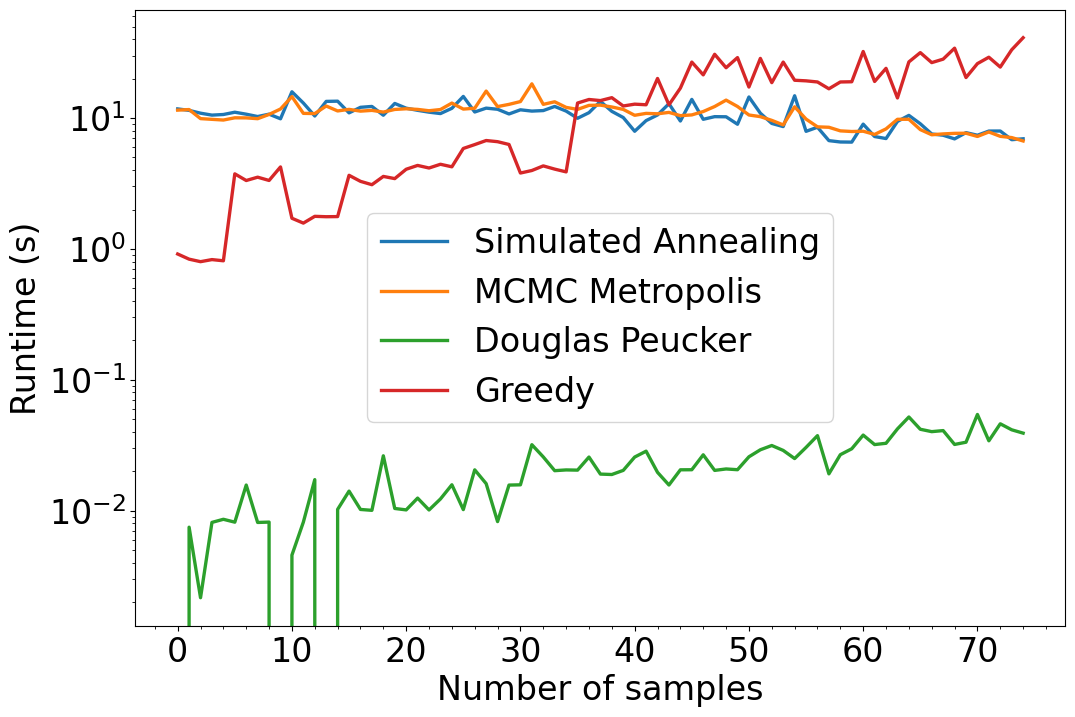

In [37]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

for method, runtime in runtimes.items():
    axs.plot(runtime, label= method)

axs.set(yscale= "log", ylabel= "Runtime (s)", xlabel= "Number of samples")
plt.legend()
plt.show()

In [38]:
mean_score, median_score, std_score, max_score, min_score, best_configurations = {}, {}, {}, {}, {}, {}
for method, best_score in best_scores.items():
    if len(best_score) > 0:
        reshaped_best_scores = np.reshape(best_score, (len(unique_reduced_points), repetitions))
        mean_score[method] = np.mean(reshaped_best_scores, axis= 1)
        median_score[method] = np.median(reshaped_best_scores, axis= 1)
        std_score[method] = np.std(reshaped_best_scores, axis= 1)
        max_score[method] = np.max(reshaped_best_scores, axis= 1)
        min_score[method] = np.min(reshaped_best_scores, axis= 1)

        best_configurations[method] = [configurations[method][best_idx + n*repetitions] for n, best_idx in enumerate(np.argmin(reshaped_best_scores, axis= 1))]

        reshaped_runtimes = np.reshape(runtimes[method], (-1, repetitions))
        median_runtimes[method] = np.median(reshaped_runtimes, axis= 1)
        mean_runtimes[method] = np.mean(reshaped_runtimes, axis= 1)


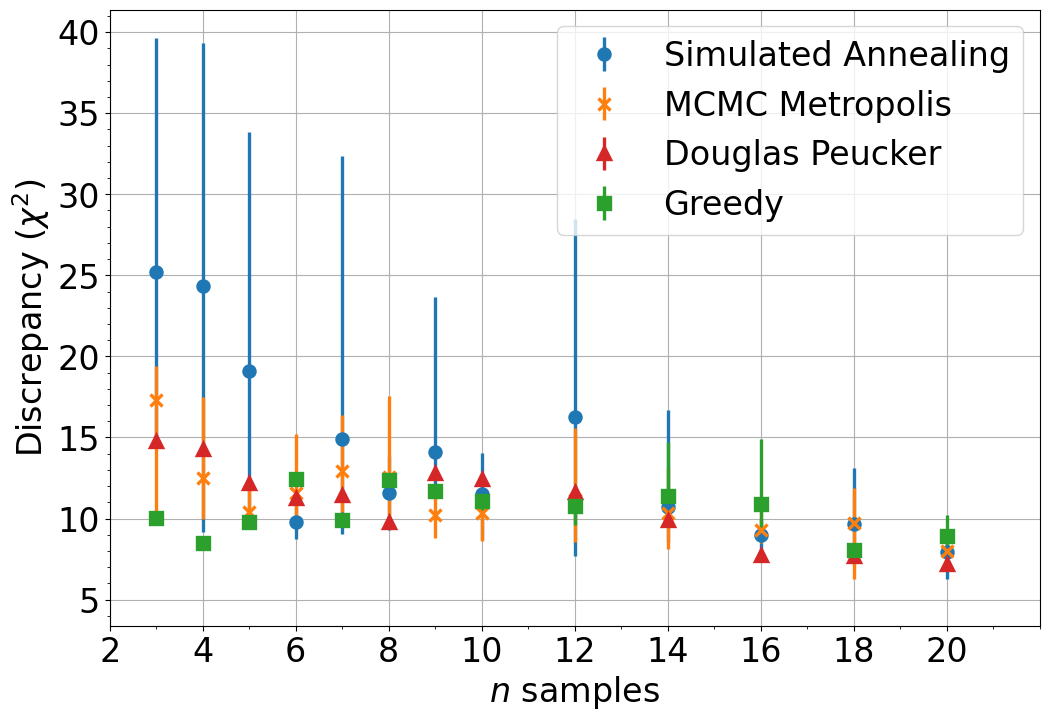

In [45]:
markers= ["o", "x", "^", "s"]
colours = ["tab:blue", "tab:orange", "tab:red", "tab:green"]

fig, axs = plt.subplots(figsize= (12,8))

for method, marker, colour in zip(["Simulated Annealing", "MCMC Metropolis", "Douglas Peucker", "Greedy"], markers, colours):
        axs.errorbar(unique_reduced_points, mean_score[method],
                     yerr= (np.abs(mean_score[method] -min_score[method]), np.abs(max_score[method] -mean_score[method])), # can contain negative values due to floating point errors
                     linestyle= "None", marker= marker, markersize= 8, color= colour, label= method)

#axs.hlines([flatline_score, noiseless_score], 0, 1, colors= "silver", transform= axs.get_yaxis_transform())
#axs.annotate("Flat line", (10,flatline_score+0.1), color= "dimgray")
#axs.annotate("Noiseless solution", (10,noiseless_score+0.1), color= "dimgray")

axs.set(xlabel= "$n$ samples",
        ylabel= r"Discrepancy ($\chi^2$)",
        #title= "Optimised Compressed Sensing to reconstruct {0:d} points".format(total_point),
        #yscale= "log",
        #yticks= [1, 2, 5, 10],
        xticks= np.arange(2, 22, 2),
        xlim= (2, 22))

minor_locator = ticker.AutoMinorLocator(2)
axs.xaxis.set_minor_locator(minor_locator)

axs.get_yaxis().set_major_formatter(ticker.ScalarFormatter()) #allows custom ticks in logscale
axs.grid(True)
axs.legend()

plt.show()